# Predicting cell phenotypes using signaling signatures 
## Filtering insigificant phosphopeptides

In [1]:
import scipy as sp, numpy as np, pandas as pd, math
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from scipy import stats
from msresist.plsr import *
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
import warnings
warnings.simplefilter("ignore")

## Importing Data

In [2]:
X = np.array(pd.read_csv('./msresist/data/ms-initial.csv', header=0))
Y = np.array(pd.read_csv('./msresist/data/ydata.csv', header=0))
treatments = np.array(pd.read_csv('./msresist/data/ms-initial.csv', header=None))[0,2:]

PC9 = X[:,2]
Erl = X[:,3]
R428 = X[:,4]
Erl_R428 = X[:,5]
Erl_HGF = X[:,6]
Erl_FGF = X[:,7]
Erl_IGF = X[:,8]
KO_Erl = X[:,9]
KO_R428 = X[:,10]
KO_Erl_R428 = X[:,11]

# Variables: X phosphopeptides 
X = np.concatenate([PC9,Erl,R428,Erl_R428,Erl_HGF,Erl_FGF,Erl_IGF,KO_Erl,KO_R428,KO_Erl_R428])
X = np.reshape(X,(10,300)) 

# Observations: Y cell viability  (average between BR 3 and 4 at 72h)
Y_cv = Y[:,2]
Y_cv = Y_cv[:10]

## 1. RAW DATA

#### Calculating and Plotting R2Y and Q2Y for 1-10 components

In [3]:
maxComp = 10
Q2Y_cv = Q2Y_across_components(X, Y_cv, maxComp+1)
R2Y_cv = R2Y_across_components(X, Y_cv, maxComp+1)

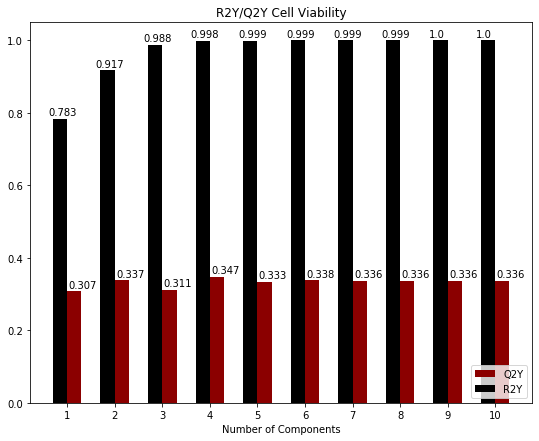

In [4]:
def truncate(f, n):
    return math.floor(f * 10 ** n) / 10 ** n

def disp_values(x,spac1,spac2,dec):
    for l, m in enumerate(x):
        plt.text(l+spac1,m+spac2,str(truncate(m,dec)))    #change to axs[ax].

range_ = np.linspace(1,maxComp,maxComp)

fig, axs = plt.subplots(1,1,figsize=(9,7))
plt.setp(axs, xticks=range_)
plt.bar(range_+0.15,Q2Y_cv,width=0.3,align='center',label='Q2Y', color = "darkred")
plt.bar(range_-0.15,R2Y_cv,width=0.3,align='center',label='R2Y', color = "black")
plt.title("R2Y/Q2Y Cell Viability")
plt.xlabel("Number of Components")
plt.legend(loc=4)
disp_values(Q2Y_cv,1.03,0.01,3)
disp_values(R2Y_cv,0.6,0.01,3)

In [5]:
plsr = PLSRegression()
parameters = {'n_components': np.arange(1, 15)}
CVresults = GridSearch_CV(plsr, X, Y_cv, parameters, cv = X.shape[0])
std_scores = {'#Components': CVresults['param_n_components'], 'std_test_scores': CVresults["std_test_score"], 'std_train_scores': CVresults["std_train_score"]}
CVresults_min = pd.DataFrame(data=std_scores)
display(CVresults_min)

KeyError: 'std_train_score'

## Leave-One-Out CV

In [ ]:
nComponents = 4
plsr_cv_raw, PC1_scores, PC2_scores, PC1_xload, PC2_xload, PC1_yload, PC2_yload = PLSR(X, Y_cv, nComponents)

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(5,5))
MeasuredVsPredicted_LOOCVplot(X,Y_cv,plsr_cv_raw, fig, "none", axs)
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(12,6))
colors_ = cm.rainbow(np.linspace(0, 1, X.shape[1]))

axs[0].scatter(PC1_scores,PC2_scores)
for j, txt in enumerate(treatments):
    axs[0].annotate(txt, (PC1_scores[j], PC2_scores[j]))
axs[0].set_title('PLSR Model Scores')
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].axhline(y=0, color='0.25', linestyle='--')
axs[0].axvline(x=0, color='0.25', linestyle='--')
axs[0].set_xlim([-18, 18])
axs[0].set_ylim([-11, 11])

axs[1].scatter(PC1_xload, PC2_xload, c=np.arange(X.shape[1]), cmap=colors.ListedColormap(colors_))
axs[1].scatter(PC1_yload, PC2_yload, color='#000000', marker='D', label='Cell Viability')
axs[1].legend(loc=4)
axs[1].set_title('PLSR Model Loadings (Averaged Clusters)')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')
axs[1].axhline(y=0, color='0.25', linestyle='--')
axs[1].axvline(x=0, color='0.25', linestyle='--')
axs[1].set_xlim([-0.15, 0.15])
axs[1].set_ylim([-0.2, 0.2])
plt.show()

# 2. Reimplementation of PLSR filtering insignificant phosphopeptides

In [ ]:
X_F = FilteringOutPeptides(X)     #10:96

In [ ]:
Q2Y_cvF = Q2Y_across_components(X_F, Y_cv, maxComp+1)
R2Y_cvF = R2Y_across_components(X_F, Y_cv, maxComp+1)

range_c = np.linspace(1,maxComp,maxComp)

fig, axs = plt.subplots(1,1,figsize=(9,7))
plt.bar(range_c+0.15,Q2Y_cvF,width=0.3,align='center',label='Q2Y', color = "blue")
plt.bar(range_c-0.15,R2Y_cvF,width=0.3,align='center',label='R2Y', color = "black")
plt.setp(axs, xticks=range_)
plt.title("R2Y/Q2Y Cell Viability")
plt.xlabel("Number of Components")
plt.legend(loc=4)
disp_values(Q2Y_cvF,1,0.01,3)
disp_values(R2Y_cvF,0.65,0.01,3)

In [ ]:
plsr = PLSRegression()
parameters = {'n_components': np.arange(1, 15)}
CVresults = GridSearch_CV(plsr, X_F, Y_cv, parameters, cv = X.shape[0])
std_scores = {'#Components': CVresults['param_n_components'], 'std_test_scores': CVresults["std_test_score"], 'std_train_scores': CVresults["std_train_score"]}
CVresults_min = pd.DataFrame(data=std_scores)
display(CVresults_min)

In [ ]:
nComponents = 2
plsr_cvF, PC1_scoresF, PC2_scoresF, PC1_xloadF, PC2_xloadF, PC1_yloadF, PC2_yloadF = PLSR(X_F, Y_cv, nComponents)

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(5,5))
MeasuredVsPredicted_LOOCVplot(X_F,Y_cv,plsr_cvF, fig, "none", axs)
plt.title("Correlation Measured vs Predicted")
plt.xlabel("Measured Cell Viability")
plt.ylabel("Predicted Cell Viability")
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(12,6))
colors_ = cm.rainbow(np.linspace(0, 1, X_F.shape[1]))

axs[0].scatter(PC1_scoresF,PC2_scoresF)
for j, txt in enumerate(treatments):
    axs[0].annotate(txt, (PC1_scoresF[j], PC2_scoresF[j]))
axs[0].set_title('PLSR Model Scores')
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].axhline(y=0, color='0.25', linestyle='--')
axs[0].axvline(x=0, color='0.25', linestyle='--')
# axs[0].set_xlim([-5, 5])
# axs[0].set_ylim([-1.75, 1.75])

axs[1].scatter(PC1_xloadF, PC2_xloadF, c=np.arange(X_F.shape[1]), cmap=colors.ListedColormap(colors_))
axs[1].scatter(PC1_yloadF, PC2_yloadF, color='#000000', marker='D', label='Cell Viability')
axs[1].legend(loc=4)
axs[1].set_title('PLSR Model Loadings (Averaged Clusters)')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')
axs[1].axhline(y=0, color='0.25', linestyle='--')
axs[1].axvline(x=0, color='0.25', linestyle='--')
# axs[1].set_xlim([-0.65, 0.65])
# axs[1].set_ylim([-1.1, 1.1])
plt.show()

# 3. Reimplementation of PLSR filtering insignificant phosphopeptides and k-means clustering

### Using separate Estimators

k-means requires us to input the number of clusters (hyperparameter) to initialize the model. To find the number of clusters that optimized the performance of our k-means estimator, we use GridSearchCV.

In [ ]:
kmeans = KMeans(init="k-means++")
parameters = {'n_clusters': np.arange(2, 30)}
CVresults = GridSearch_CV(kmeans, X_F.T, None, parameters, cv = X_F.T.shape[0])
std_scores = {'#Clusters': CVresults['param_n_clusters'], 'std_test_scores': CVresults["std_test_score"], 'std_train_scores': CVresults["std_train_score"]}
CVresults_min = pd.DataFrame(data=std_scores)
display(CVresults_min)

It looks like 5 clusters would make our model perform within the 1 std range

In [ ]:
n_clusters = 5
kmeans = KMeans(init="k-means++", n_clusters=n_clusters)
cluster_assignments = kmeans.fit_predict(X_F.T)    #we want X_F in 96:10
centers = np.array(kmeans.cluster_centers_).T

In [ ]:
nObs = Y_cv.shape[0]
X_Filt_Clust_Avgs = ClusterAverages((X_F), cluster_assignments, n_clusters, nObs)
print(X_Filt_Clust_Avgs)
print("-----")
print(centers)

In [ ]:
maxComp = n_clusters
Q2Y_cvFC = Q2Y_across_components(X_Filt_Clust_Avgs, Y_cv, maxComp+1)
R2Y_cvFC = R2Y_across_components(X_Filt_Clust_Avgs, Y_cv, maxComp+1)

range_c = np.linspace(1,n_clusters,n_clusters)

fig, axs = plt.subplots(1,1,figsize=(6,6))
plt.bar(range_c+0.15,Q2Y_cvFC,width=0.3,align='center',label='Q2Y', color = "darkgreen")
plt.bar(range_c-0.15,R2Y_cvFC,width=0.3,align='center',label='R2Y', color = "black")
plt.title("R2Y/Q2Y Cell Viability")
plt.xlabel("Number of Components")
plt.legend(loc=4)
disp_values(Q2Y_cvFC,1,0.01,3)
disp_values(R2Y_cvFC,0.65,0.01,3)

In [ ]:
plsr = PLSRegression()
parameters = {'n_components': np.arange(1, centers.shape[1] + 1)}
CVresults = GridSearch_CV(plsr, centers, Y_cv, parameters, cv = centers.shape[0])
std_scores = {'#Components': CVresults['param_n_components'], 'std_test_scores': CVresults["std_test_score"], 'std_train_scores': CVresults["std_train_score"]}
CVresults_min = pd.DataFrame(data=std_scores)
display(CVresults_min)

In [ ]:
nComponents = 2
plsr_cvFC, PC1_scoresFC, PC2_scoresFC, PC1_xloadFC, PC2_xloadFC, PC1_yloadFC, PC2_yloadFC = PLSR(X_Filt_Clust_Avgs, Y_cv, nComponents)

In [ ]:
print(PC1_scoresFC)

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(5,5))
MeasuredVsPredicted_LOOCVplot(X_Filt_Clust_Avgs,Y_cv,plsr_cvFC, fig, "none", axs)
plt.title("Correlation Measured vs Predicted")
plt.xlabel("Measured Cell Viability")
plt.ylabel("Predicted Cell Viability")
plt.show()

In [ ]:
cc

In [ ]:
from ete3 import TreeStyle